# 卷积网络lenet-5

In [65]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
from torch.utils import data
from d2l import torch as d2l

In [66]:
#将形状调整
class Reshape(torch.nn.Module):
    def forward(self,x):
        return x.view(-1,1,28,28)
   
#网络模型
net=nn.Sequential(Reshape(),nn.Conv2d(1,6,kernel_size=5,padding=2),nn.Sigmoid(),
                nn.AvgPool2d(kernel_size=2,stride=2),nn.Conv2d(6,16,kernel_size=5),nn.Sigmoid(),
                nn.AvgPool2d(kernel_size=2,stride=2),nn.Flatten(),
                nn.Linear(16*5*5,120),nn.Sigmoid(),
                nn.Linear(120,84),nn.Sigmoid(),
                nn.Linear(84,10))  

epoch:1,loss 2.327, train acc 0.108,test acc 0.260
epoch:2,loss 1.222, train acc 0.519,test acc 0.559
epoch:3,loss 0.848, train acc 0.670,test acc 0.717
epoch:4,loss 0.706, train acc 0.723,test acc 0.735
epoch:5,loss 0.642, train acc 0.749,test acc 0.740
epoch:6,loss 0.594, train acc 0.770,test acc 0.726
epoch:7,loss 0.545, train acc 0.791,test acc 0.794
epoch:8,loss 0.517, train acc 0.804,test acc 0.740
epoch:9,loss 0.491, train acc 0.813,test acc 0.797
epoch:10,loss 0.469, train acc 0.824,test acc 0.794


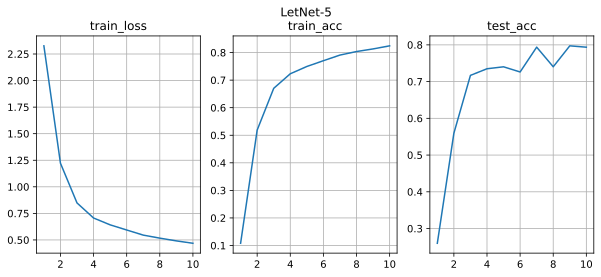

预测的结果为:
第2层的w,b参数为 Parameter containing:
tensor([[[[-0.0279, -0.0381, -0.0967, -0.4701, -0.3250],
          [-0.0332, -0.2707, -0.5334, -0.4480, -0.2613],
          [-0.1330, -0.5133, -0.6161, -0.4378, -0.2802],
          [ 0.0092, -0.2271, -0.2708, -0.2977, -0.3503],
          [ 0.0144, -0.2554, -0.0722, -0.2497, -0.0300]]],


        [[[-0.7230,  0.1716,  0.5358,  0.6327, -0.1111],
          [-0.3585,  0.1791,  0.4328,  0.8521,  0.0360],
          [-0.3444,  0.6330,  0.6183,  0.8956,  0.3306],
          [-0.0079,  0.5652,  0.8405,  0.5560,  0.2799],
          [-0.0846,  0.1999,  0.5399,  0.4457, -0.0756]]],


        [[[ 0.8275, -0.1029, -0.8494, -0.3858,  0.8298],
          [ 0.6664, -0.7490, -2.4427, -1.4992,  0.6380],
          [ 0.6853, -0.8030, -2.7889, -1.4949,  0.5837],
          [ 1.3079, -0.1251, -1.7456, -0.5801,  0.7965],
          [ 1.6197,  0.0667, -0.7417, -0.2906,  1.0924]]],


        [[[ 0.0620,  0.0993, -0.1437,  0.0397,  0.1082],
          [ 0.3397, -0.1110, -0.438

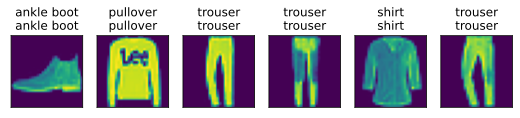

In [111]:
#训练
a=[]
b=[]
train_acc_num=[]
test_acc_num=[]
def load_data_fashion_mnist(batch_size):
    trans = transforms.ToTensor()#通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式
    mnist_train = torchvision.datasets.FashionMNIST(
        root="./datas", train=True, transform=trans, download=False)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="./datas", train=False, transform=trans, download=False)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=4),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=4))
batch_size=256
train_iter,test_iter=load_data_fashion_mnist(batch_size)#分成256份包括训练和验证
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    net.to(device)
    updater = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            updater.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            updater.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]   
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        a.append(epoch+1)
        b.append(train_l)
        train_acc_num.append(train_acc)
        test_acc_num.append(test_acc)
        print(f'epoch:{epoch+1},loss {train_l:.3f}, train acc {train_acc:.3f},test acc {test_acc:.3f}')
    
#超参数    
lr, num_epochs = 0.92, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
#可视化
plt.figure(figsize=(10,4))
plt.suptitle("LetNet-5")

plt.subplot(1,3,1)
plt.plot(a,b)
plt.grid()
plt.title("train_loss")

plt.subplot(1,3,2)
plt.plot(a,train_acc_num)
plt.grid()
plt.title("train_acc")

plt.subplot(1,3,3)
plt.plot(a,test_acc_num)
plt.grid()
plt.title("test_acc")

plt.show()
#验证集的预测
print("预测的结果为:")
d2l.predict(net,test_iter)
#最后网络的更新值
for i in range(len(net)): 
    for params in net[i].parameters():  
        print(f"第{i+1}层的w,b参数为",params)

# AlexNet网络架构（2012）

In [31]:
import torch
import torchvision
from torch import nn
from torchvision import tranforms
from torch.utils import data
from d2l import torch as d2l

# VGG-11网络构架

In [28]:
import torch
from torch import nn
from d2l import torch as d2l

In [29]:
#定义vgg的网络块
def vgg_block(num_conv,in_channels,out_channels):
    layers=[]
    for _ in range(num_conv):
        layers.append(nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1))
        layers.append(nn.ReLU())
        in_channels=out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)
#自定义每个块的卷积层数和通道数
conv_cc=((1,64),(1,128),(2, 256), (2, 512), (2, 512))
#定义vgg-11架构
def vgg11(conv_cc):
    conv_vgg=[]
    in_channels=1
    for (num_conv,out_channels) in conv_cc:
        conv_vgg.append(vgg_block(num_conv,in_channels,out_channels))
        in_channels=out_channels
    return nn.Sequential(*conv_vgg,nn.Flatten(),
                       nn.Linear(out_channels*7*7,4096),nn.ReLU(),nn.Dropout(0.5),
                       nn.Linear(4096,4096),nn.ReLU(),nn.Dropout(0.5),
                       nn.Linear(4096,10))   
net=vgg11(conv_cc)
#测试
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


training on cpu


Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/envs/deeplearning/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/envs/deeplearning/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/envs/deeplearning/lib/python3.9/multiprocessing/connection.py", line 416, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda3/envs/deeplearning/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/envs/deeplearning/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/envs/deeplearning/lib/python3.9/multiprocessing/connection.py", line 416, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda3/envs/deeplearning/lib/python3.9/multiprocessing/connection.py", lin

KeyboardInterrupt: 

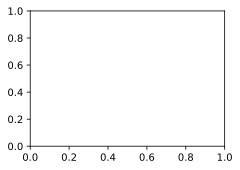

In [30]:
#定义小的通道数
ra=4
small_conv_cc=((conv[0],conv[1]//ra) for conv in conv_cc)
net=vgg11(small_conv_cc)
#训练
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
d2l.predict_pic(net,test_iter)
print("success")